# Time Series Forecasting with ARIMA models

This notebook presents a simple time series evaluation and forecasting using ARIMA models. We use the PeMSD7 dataset, which is a traffic dataset that contains 228 time series. This data is intended to be used to study graph machine learning methods, but we use only one of the 228 series to study ARIMA models.

### Imports and plot parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from pandas import DataFrame

In [2]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16
})

### Data - PeMSD7 Dataset

In [3]:
data = pd.read_csv('Data/PeMSD7_V_228.csv', header=None).to_numpy()
data.shape

(12672, 228)

The shape of the dataset matches what was previously described

We take only one of the time series for the models we are going to test. The data was sampled from speed sensors accros California in a 30 seconds interval, but it was aggregated in a 5 minutes interval. With this information we can define the time axis 

In [4]:
x = data[:, 0]
t = np.arange(0, len(x)/12, 1/12)

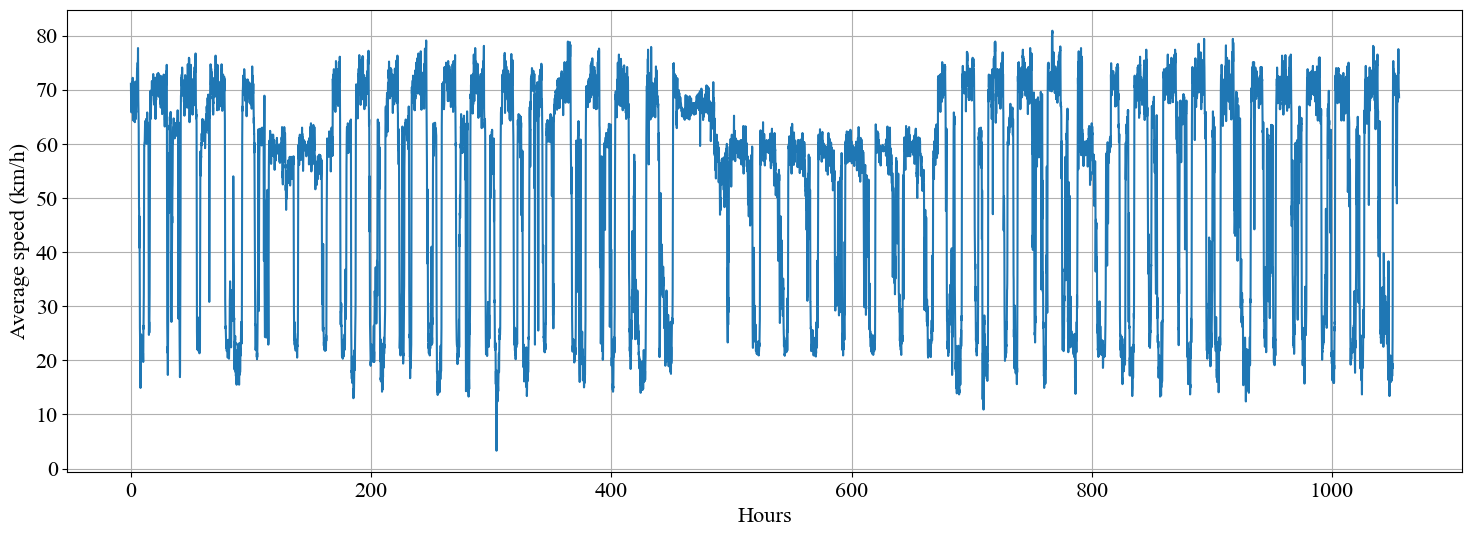

In [5]:
plt.figure(figsize=(18,6))
plt.plot(t, x)
plt.xlabel('Hours')
plt.ylabel('Average speed (km/h)')
plt.grid()

We take only the first 2000 samples to fit the model. More data would make the fitting process slower and there wouldn't be much improvement in the results 

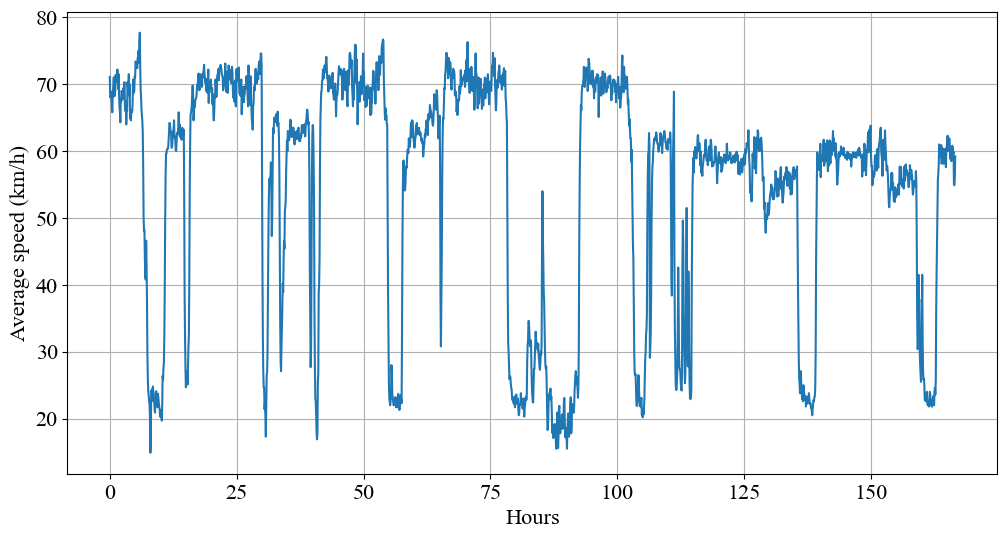

In [7]:
size = 2000
plt.figure(figsize=(12,6))
plt.plot(t[:size], x[:size])
plt.xlabel('Hours')
plt.ylabel('Average speed (km/h)')
plt.grid()

## Determining the order of the model

The first step to determine the order of an ARIMA model for a time series is to evaluate the stationarity of the series, and this is done through the ADF test. If the data is not stationary, differencing is needed until this property is achieved. In more complex time series data, stationarity cannot be achieved through differencing, but in such cases a more complex model is required in order to do the forecasting.

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
adfuller(x)[1]

4.548618937344271e-25

The test returned a p-value of $4.55 \times 10^{-25}$, which indicates that the null hypothesis of a root in the unit circle can be rejected, and the data can be treated as stationary, that is $d=0$ in the ARIMA model.

After the ADF test we evaluate the Autocorrelation and Parcial Autocorrelation plots

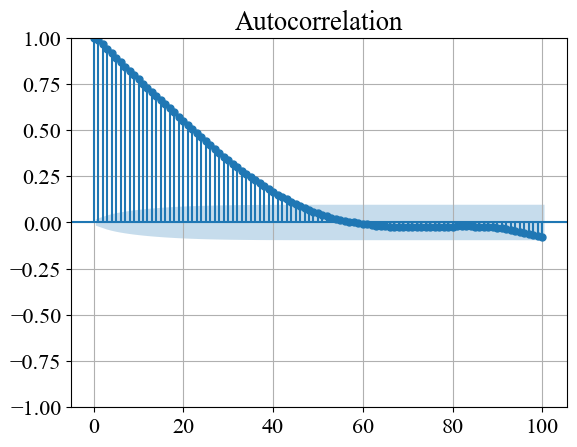

In [10]:
plot_acf(x, lags=100)
plt.grid()

The autocorrelations are significant for a large number of lags but the autocorrelations at lags 2 and above are merely due to the propagation of the autocorrelation at lag 1. This is confirmed by the PACF plot

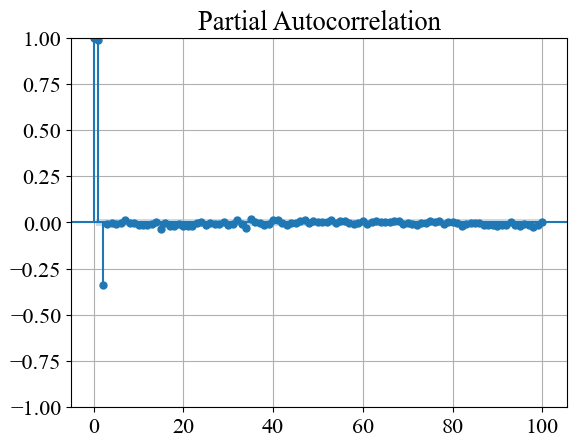

In [11]:
plot_pacf(x, lags=100)
plt.grid()

The PACF plot indicates that a low order model would already be enough to properly model the data. Therefore, the grid search was done using in the intervals $[1, 3]$ for $p$ and $q$ and $[0, 1]$ for $d$. Even tough we already knew that the data was stationary, $d=1$ was tested in order to see if the model would perform better by removing trends of any sort.

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Evaluate model function

In [13]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

### Grid search function

In [16]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
 dataset = dataset.astype('float32')
 best_score, best_cfg = float("inf"), None
 for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            print(f'order = {order}')
            mse = evaluate_arima_model(dataset, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.5f' % (order,mse))
 
 print('Best ARIMA%s MSE=%.5f' % (best_cfg, best_score))
 return best_cfg

In [15]:
import warnings
warnings.filterwarnings("ignore")

Here we perform the grid search in the mentioned intervals

In [17]:
p_val = range(1, 3)
d_val = [0, 1]
q_val = range(1, 3)
size = 1000
order = evaluate_models(x[:1000], p_val, d_val, q_val)

order = (1, 0, 1)
ARIMA(1, 0, 1) MSE=5.77220
order = (1, 0, 2)
ARIMA(1, 0, 2) MSE=5.74528
order = (1, 1, 1)
order = (1, 1, 2)
order = (2, 0, 1)
order = (2, 0, 2)
order = (2, 1, 1)
order = (2, 1, 2)
Best ARIMA(1, 0, 2) MSE=5.74528


The function returned the best ARIMA model as the (1, 0, 2) model, which is an ARMA model, since d=0

Redefining the data as the first 2000 samples in order to do the forecasting

In [18]:
x_red = x[:size]
t_red = t[:size]

Fitting the model and evaluating fit

In [20]:
model = ARIMA(x_red, order=order)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2387.307
Date:                Wed, 19 Jun 2024   AIC                           4784.613
Time:                        10:27:20   BIC                           4809.152
Sample:                             0   HQIC                          4793.939
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2291      4.908     12.068      0.000      49.609      68.849
ar.L1          0.9701      0.009    107.688      0.000       0.952       0.988
ma.L1          0.4343      0.022     19.700      0.0

Through the residuals we can see that the model is properly fitted

<Axes: >

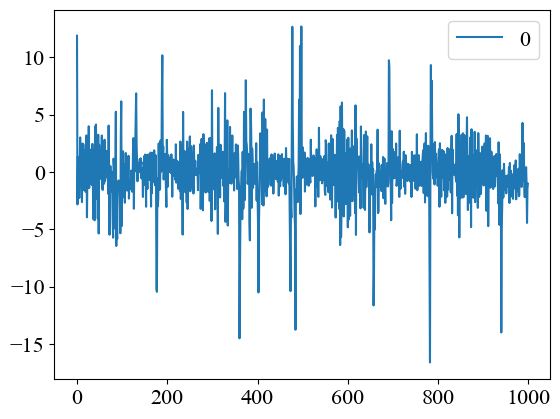

In [21]:
residuals = DataFrame(model_fit.resid)
residuals.plot()

In [22]:
print(residuals.describe())

                 0
count  1000.000000
mean     -0.017198
std       2.655994
min     -16.624729
25%      -1.226816
50%       0.029222
75%       1.350458
max      12.681672


The residuals are randomly distributed around 0, which indicates a correct fit. An incorrect fit would be seen through trends in the residuals

Here we fit an incorrect model to exemplify what would an incorrect fit be 

In [23]:
model2 = ARIMA(x_red, order=(0,0,2))
model2_fit = model2.fit()

<Axes: >

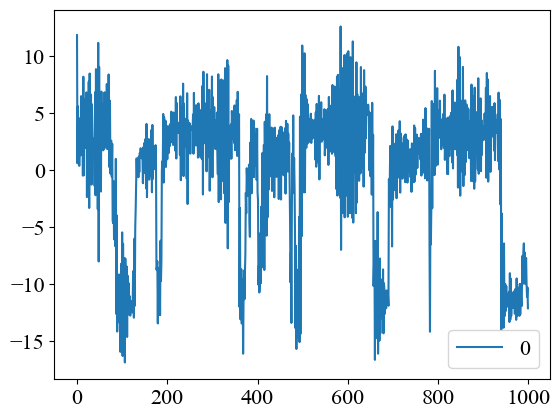

In [24]:
residuals2 = DataFrame(model2_fit.resid)
residuals2.plot()

In [26]:
print(residuals2.describe())

                 0
count  1000.000000
mean      0.001560
std       6.036441
min     -16.854599
25%      -2.119417
50%       1.659237
75%       4.058340
max      12.634335


We can see that although the residuals are distributed around 0, there is a pattern of some sort in the residuals which indicates information in the data that is not being captured by the model

Next we define the function to do the forecasting over the test data. This function works by first fitting the model to the train data, then forecasting $n$ steps, comparing the forecasted values with the real values from the test set, adding the real values to the data and fitting the model again for all values in the test set

In [27]:
def forecast(x, split, order=(1, 0, 2), steps=1, print_res=True):
    size = int(len(x)*split)
    train, test = x[:size], x[size:]
    history = [x for x in train]
    predictions = list()
    t=0
    while t < len(test):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=steps)
        if steps == 1:
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            t += 1
            if print_res:
                print(f'predicted = {yhat}, expected = {obs}')
        else:
            for yhat in output:
                if (t >= len(test)): break
                predictions.append(yhat)
                obs = test[t]
                history.append(obs)
                t += 1
    return predictions, train, test

Here we do the forecasting using the same model

In [ ]:
steps = [1, 5, 10]
pred = []
tests = []
for step in steps:
    predictions, _, test = forecast(x_red, 0.8, step, False)
    pred.append(predictions)

    tests.append(test)

In [ ]:
for prediction, test in zip(pred, tests):
    rmse = np.sqrt(mean_squared_error(test, prediction))
    mae = mean_absolute_error(test, prediction)
    print(f'test RMSE = {rmse:.5f}')
    print(f'test MAE = {mae:.5f}')

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(t2_red[int(len(x_red)-len(predictions)):], x_red[int(len(x_red)-len(predictions)):], label='Test data', color='r')
for predictions, step in zip(pred, steps):
    plt.plot(t2_red[int(len(x_red)-len(predictions)):], predictions, label=f'{step} steps')
plt.ylabel('Average speed (km/h)')
plt.xlabel('Hours')
plt.legend()
plt.grid()

save_fig('arima_comparison')

In [ ]:
rmse = [[], [], []]
mae = [[], [], []]
i=0
for prediction, test in zip(pred, tests):
    for yhat, y in zip(prediction, test):
        rmse[i].append(np.sqrt(mean_squared_error([y], [yhat])))
        mae[i].append(mean_absolute_error([y], [yhat]))
    i += 1

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(t2_red[int(len(x_red)-len(predictions)):], x_red[int(len(x_red)-len(predictions)):], label='Test data', color='r')
for predictions, step in zip(mae, steps):
    plt.plot(t2_red[int(len(x_red)-len(predictions)):], predictions, label=f'{step} steps')
plt.ylabel('Average speed (km/h)')
plt.xlabel('Hours')
plt.legend()
plt.grid()

In [ ]:
steps2 = [x for x in range(1, 30)]
mae = list()
rmse = list()

for step in steps2:
    predictions, _, test = forecast(x_red, 0.8, step, False)
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))
    mae.append(mean_absolute_error(test, predictions))

In [ ]:
plt.plot(steps2[:20], mae[:20])
plt.grid()
plt.xlabel('Number of predicted steps')
plt.ylabel('Mean Absolute Error')
save_fig('mae')

In [ ]:
plt.plot(steps2[:20], rmse[:20])
plt.grid()
plt.xlabel('Number of predicted steps')
plt.ylabel('Root Mean Squared Error')
save_fig('rmse')

In [ ]:
split = 0.25
xlen = 100
pred0, _, test0 = forecast(x_red[:xlen], split, print_res=False)
print(f'RMSE = {np.sqrt(mean_squared_error(test0, pred0)):.5f}')
print(f'MAE = {mean_absolute_error(test0, pred0):.5f}')

In [ ]:
plt.plot(test0, label='Test data')
plt.plot(pred0, label='Forecast')
plt.legend()

In [ ]:
split = [0.25, 0.5, ]
x_len = [200, 200, 400, 600, 800, 1000]
mae = list()
rmse = list()

for s in split:
    print(s)
    predictions, _, test = forecast(x_red, s, False)
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))
    mae.append(mean_absolute_error(test, predictions))